In [1]:
import os, sys, io, time
import numpy as np
from multihist import Histdd, Hist1d
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from scipy.optimize import curve_fit, minimize
pd.options.mode.chained_assignment = None        # default='warn'
import warnings
warnings.filterwarnings('ignore')

from scipy.interpolate import interp1d, InterpolatedUnivariateSpline

from numpy import sqrt, exp, pi, square
from tqdm import tqdm
from multiprocessing import Pool
from pax.utils import Memoize
from numba import vectorize, guvectorize, int64, int32

def plt_config(title = None, xbounds = None, ybounds = None, xlabel = None, ylabel = None, colorbar = False, sci = False):
    if isinstance(sci, str): plt.ticklabel_format(style='sci', axis=sci, scilimits=(0,0))
    if title != None: plt.title(title)
    if xbounds != None: plt.xlim(xbounds)
    if ybounds != None: plt.ylim(ybounds)
    if xlabel != None: plt.xlabel(xlabel)
    if ylabel != None:  plt.ylabel(ylabel)
    if isinstance(colorbar,str): plt.colorbar(label = colorbar)
    elif colorbar: plt.colorbar(label = '$Number\ of\ Entries$')
    else: pass

In [2]:
# Just check existing file and put that into a list
class dummy_read_n_merge():
    __version__ = '0.1.6'

    def process(self,
                indir_larges2='', indir_peak='', indir_elist='',
                outdir_peak='', outdir_elist='', number_file_cap=0):

        self.indir = dict(larges2 = indir_larges2, peak = indir_peak, elist = indir_elist)
        self.outdir = dict(larges2 = indir_larges2, peak = outdir_peak, elist = outdir_elist)

        # Record all the file in folder, and put a cup on number of files
        file_list = [[f for f in os.listdir(d) if 'pkl' in f] for d in self.indir.values()]
        file_list = list(set(file_list[0]).intersection(file_list[1]).intersection(file_list[2]))

        self.file_list = file_list[:number_file_cap]

io_dir = dict (
    indir_elist = '/project2/lgrandi/zhut/data/ce/Sciencerun1_None_CE/Elist/', # Elist In
    indir_larges2 = '/project2/lgrandi/zhut/data/ce/Sciencerun1_None_CE/LargeS2/', # Large S2 In
    indir_peak = '/project2/lgrandi/zhut/data/ce/Sciencerun1_None_CE/PreTriggerPeaks/', # Pre Trigger Peak In
    outdir_elist = '/project2/lgrandi/zhut/data/ce/Sciencerun1_None_CE/Elist_Processed/', # Processed Peak Out
    outdir_peak = '/project2/lgrandi/zhut/data/ce/Sciencerun1_None_CE/Peaks_Processed/',) # Processed Elist Out

In [3]:
drnm = dummy_read_n_merge()
drnm.process(number_file_cap = 1000, **io_dir)
flist = drnm.file_list

import json
with open('/home/zhut/Cool_Electrons/data/FileList.json', 'w') as outfile:
    json.dump(flist, outfile)

# Here define the function to read data but without doing so
def load_data(outdir_key):
    cache = []
    with tqdm(total=len(flist)) as pBar:
        for file in flist:
            pBar.update(1)
            cache.append(pd.read_pickle(os.path.join(io_dir[outdir_key], file)))
    return pd.concat(cache)

In [16]:
print('loading data..')
time.sleep(1)

df = load_data('outdir_peak')
print('Total dataframe size %.4e' % df.size)
basic_selections = '(type == "s2") & ((nearest_busy < -500e6) | (nearest_busy > 100e6)) & (inside_flash == 0)'

df = df[df.eval(basic_selections)]
df.drop(['goodness_of_fit_nn', 'goodness_of_fit_tpf','x_nn','y_nn','x_tpf','y_tpf','x_nn','y_nn','inside_flash',
    'nearest_flash', 'previous_busy', 'previous_event', 'previous_hev','previous_muon_veto_trigger',
    'range_80p_area', 'range_90p_area', 'rise_time','hit_time_mean','left','type'
        ], axis = 1, inplace = True)
print('After basic reduction dataframe size %.4e' % df.size)

loading data..


100%|██████████| 1000/1000 [00:59<00:00, 16.72it/s]


Total dataframe size 1.8961e+08
After basic reduction dataframe size 7.6940e+07


In [49]:
t = pd.read_pickle(os.path.join(io_dir['outdir_peak'], flist[0]))

In [51]:
t.columns

Index(['area', 'area_fraction_top', 'event_number', 'global_event_number',
       'goodness_of_fit_nn', 'goodness_of_fit_tpf', 'hit_time_mean',
       'hit_time_mean_global', 'left', 'range_50p_area', 'range_80p_area',
       'range_90p_area', 'rise_time', 'run_number', 'sum_s1s_before',
       'sum_s2s_before', 'type', 'x_nn', 'x_tpf', 'y_nn', 'y_tpf',
       'previous_s2_areas', 'previous_s2_times', 'previous_largest_s2_area',
       'previous_largest_s2_index', 'previous_largest_s2_time', 'nearest_busy',
       'previous_busy', 'previous_event', 'previous_hev',
       'previous_muon_veto_trigger', 'inside_flash', 'nearest_flash'],
      dtype='object')

In [21]:
time_range = [0, 1500]
time_bin_edges = np.linspace(time_range[0]*1e6, time_range[1]*1e6, 1500+1)
time_bin_centers = 0.5*(time_bin_edges[:-1] + time_bin_edges[1:])
D1lt = np.loadtxt('/home/zhut/Cool_Electrons/data/D1lt.txt', delimiter=' ')

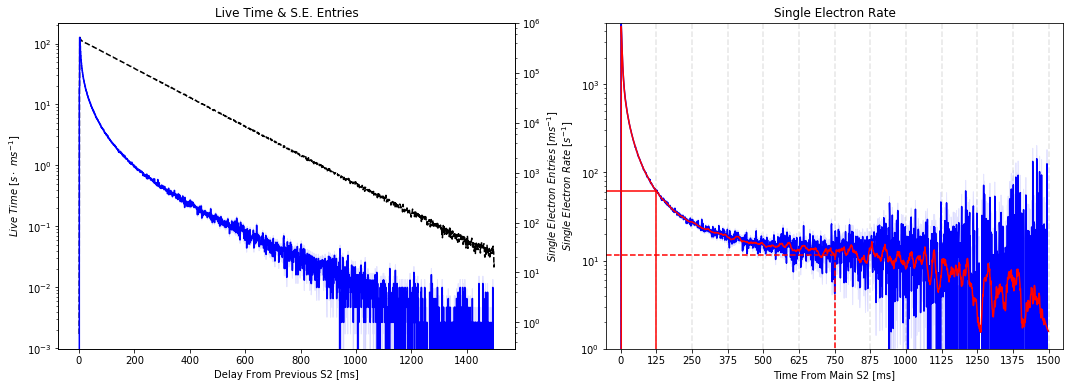

In [22]:
plt.rcParams['figure.figsize'] = (18, 6)
fig = plt.figure()

########################################################################
ax = fig.add_subplot(121)
plt.plot(time_bin_centers/1e6, D1lt, color = 'k', ls = '--')
plt_config(title = 'Live Time & S.E. Entries', xlabel = 'Delay From Previous S2 [ms]', ylabel = '$Live\ Time\ [s\cdot\ ms^{-1}]$')
plt.yscale('log')

ax_t = ax.twinx()
df['delay'] = df.hit_time_mean_global - df.previous_largest_s2_time
little_selection = ['(sum_s1s_before < 1000)', '(sum_s2s_before < 10000)',
                    '(nearest_busy/1e6 > 100) | (nearest_busy/1e6 < -500)',]
little_selection = '&'.join(little_selection)

dfs = ['df[df.eval(little_selection)]']
argx = '{df}.delay/1e6'
ph = Hist1d(eval(argx.format(df = dfs[0])), bins = time_bin_edges/1e6) # So x is in ms, y is in entries / (time_range/1000)
upper_err, lower_err = lambda n: n+sqrt(n), lambda n: n-sqrt(n)
plt.fill_between(ph.bin_centers, lower_err(ph.histogram),upper_err(ph.histogram), color='b', alpha=0.1)
ph.plot(color='b')
plt_config(ylabel = '$Single\ Electron\ Entries\ [ms^{-1}]$')
plt.yscale('log')

########################################################################
ax = fig.add_subplot(122)
rate = ph.histogram/D1lt

plt.plot(ph.bin_centers, rate, color='b')
plt.fill_between(ph.bin_centers, lower_err(ph.histogram)/D1lt,upper_err(ph.histogram)/D1lt, color='b', alpha=0.1)

from scipy.signal import savgol_filter
y = np.log10(rate)[2:]; y[y<0] = 0
y_smooth = savgol_filter(y, window_length = 31, polyorder = 3)
intp = interp1d(ph.bin_centers[2:], 10**y_smooth, fill_value = [-4], bounds_error = False)

plt.plot(np.linspace(-50,125,10),intp(125)*np.ones(10), 125*np.ones(10), np.linspace(1e-6,intp(125),10),color = 'r')
plt.plot(np.linspace(-50,750,10),intp(750)*np.ones(10), 750*np.ones(10), np.linspace(1e-6,intp(750),10),color = 'r', ls = '--')
plt.plot(ph.bin_centers, intp(ph.bin_centers), 'r')

plt_config(title = 'Single Electron Rate', xlabel = 'Time From Main S2 [ms]', ylabel = '$Single\ Electron\ Rate\ [s^{-1}]$',
           xbounds = [-50, 1550], ybounds = [1, 5e3],)
plt.yscale('log'); plt.xticks(np.linspace(0,1500,13))
plt.grid(color = 'grey', ls = '--', lw = 0.3, axis = 'x')

plt.show()

In [24]:
# Adjust area
area_sum = []
with tqdm(total = len(df)) as pBar:
    for ix, areas in enumerate(df.previous_s2_areas):
        pBar.update(1)
        area_sum.append(np.sum(areas))
            
df['previous_largest_s2_area_sum'] = area_sum

100%|██████████| 5129342/5129342 [00:21<00:00, 238338.58it/s]


In [25]:
time_range = [0, 1500]
time_bin_edges = np.linspace(time_range[0]*1e6, time_range[1]*1e6, 1500+1)
time_bin_centers = 0.5*(time_bin_edges[:-1] + time_bin_edges[1:])

area_range = [1e2, 1e8]
area_bin_edges = np.logspace(np.log10(area_range[0]),  np.log10(area_range[1]), 101)
area_bin_centers = sqrt(area_bin_edges[:-1]*area_bin_edges[1:])

D2lt = np.loadtxt('/home/zhut/Cool_Electrons/data/D2lt.txt', delimiter=' ')

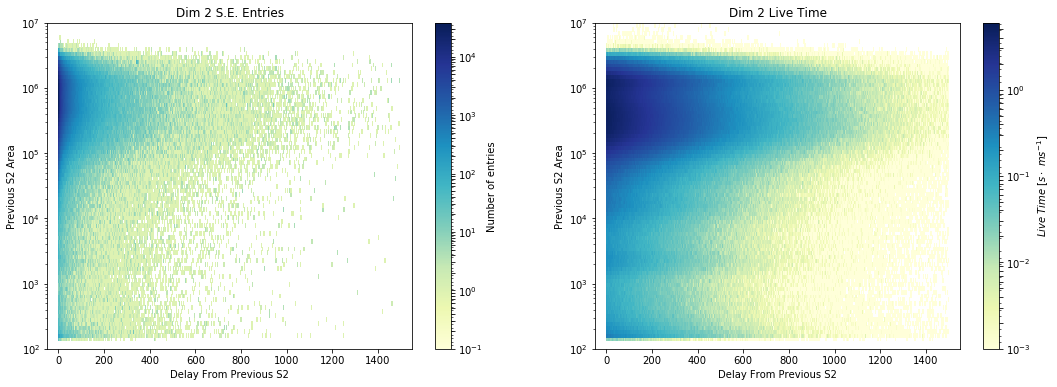

In [27]:
plt.rcParams['figure.figsize'] = (18, 6)
fig = plt.figure()

########################################################################
ax = fig.add_subplot(121)
argx, argy = '{df}.delay/1e6', '{df}.previous_largest_s2_area_sum'
dfs = ['df[df.eval(little_selection)]']
df['delay'] = df.hit_time_mean_global - df.previous_largest_s2_time

little_selection = ['(sum_s1s_before < 1000)', '(sum_s2s_before < 10000)',
                    '(nearest_busy/1e6 > 100) | (nearest_busy/1e6 < -500)',
                    '(previous_largest_s2_area_sum > 0)']
little_selection = '&'.join(little_selection)

mh = Histdd(eval(argx.format(df = dfs[0])), eval(argy.format(df = dfs[0])),
            bins=[time_bin_edges/1e6, area_bin_edges])

mh.plot(log_scale = True, cmap=plt.get_cmap('YlGnBu'), log_scale_vmin=1e-1,
        alpha = 1.0, cblabel='Number of entries')
plt.yscale('log')
plt_config(xbounds = [-50, 1550], ybounds = [1e2, 1e7], title = 'Dim 2 S.E. Entries',
           xlabel = 'Delay From Previous S2', ylabel = 'Previous S2 Area')

########################################################################
ax = fig.add_subplot(122)
mh_lt = Histdd.from_histogram(D2lt, mh.bin_edges)
mh_lt.plot(log_scale = True, cmap=plt.get_cmap('YlGnBu'), log_scale_vmin=1e-3, 
           alpha = 1.0, cblabel='$Live\ Time\ [s\cdot\ ms^{-1}]$')
plt.yscale('log')
plt_config(xbounds = [-50, 1550], ybounds = [1e2, 1e7], title = 'Dim 2 Live Time',
           xlabel = 'Delay From Previous S2', ylabel = 'Previous S2 Area')

plt.show()

In [ ]:
# Now the question is how what can I do with those two distribution?


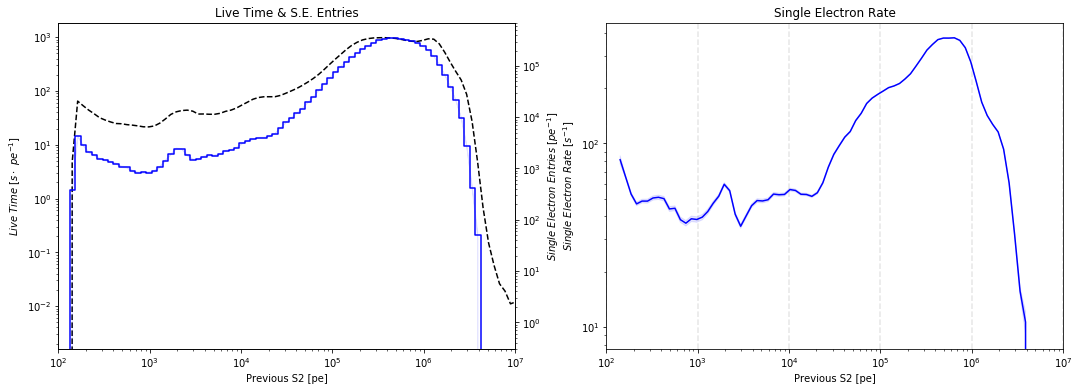

In [30]:
plt.rcParams['figure.figsize'] = (18, 6)
fig = plt.figure()

########################################################################
ax = fig.add_subplot(121)
plt.plot(area_bin_centers, np.sum(D2lt, axis=0), color = 'k', ls = '--')
plt_config(title = 'Live Time & S.E. Entries', xlabel = 'Previous S2 [pe]', ylabel = '$Live\ Time\ [s\cdot\ pe^{-1}]$')
plt.xscale('log'); plt.yscale('log')

ax_t = ax.twinx()
ph = Hist1d(df.previous_largest_s2_area, bins = area_bin_edges) # So x is in ms, y is in entries / (time_range/1000)
upper_err, lower_err = lambda n: n+sqrt(n), lambda n: n-sqrt(n)
plt.fill_between(ph.bin_centers, lower_err(ph.histogram),upper_err(ph.histogram), color='b', alpha=0.1)
ph.plot(color='b')
plt_config(ylabel = '$Single\ Electron\ Entries\ [pe^{-1}]$', xbounds = [1e2, 1e7])
plt.yscale('log')

########################################################################
ax = fig.add_subplot(122)
rate = ph.histogram/np.sum(D2lt, axis=0)

plt.plot(ph.bin_centers, rate, color='b')
plt.fill_between(ph.bin_centers, lower_err(ph.histogram)/np.sum(D2lt, axis=0),
                 upper_err(ph.histogram)/np.sum(D2lt, axis=0), color='b', alpha=0.1)

plt_config(title = 'Single Electron Rate', xlabel = 'Previous S2 [pe]', ylabel = '$Single\ Electron\ Rate\ [s^{-1}]$',
           xbounds = [1e2, 1e7])
plt.xscale('log'); plt.yscale('log'); #plt.xticks(np.linspace(0,1500,13))
plt.grid(color = 'grey', ls = '--', lw = 0.3, axis = 'x')

plt.show()

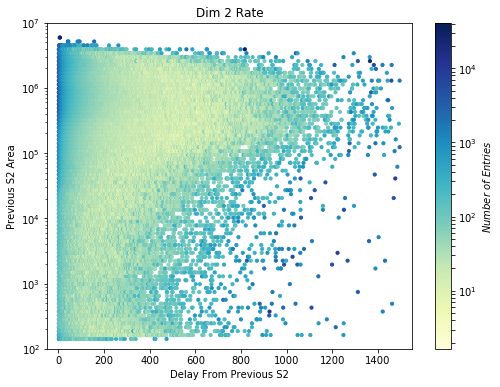

In [28]:
plt.rcParams['figure.figsize'] = (18, 6)
fig = plt.figure()

########################################################################
ax = fig.add_subplot(121)
rate = np.true_divide(mh.histogram, mh_lt.histogram)
rate[np.isnan(rate)] = 0
rate[np.isinf(rate)] = 0

grid = np.array(np.meshgrid(mh.bin_centers(axis=0), mh.bin_centers(axis=1), indexing = 'ij'))
plt.scatter(grid[0], grid[1], c = rate, cmap = plt.get_cmap('YlGnBu'), norm = LogNorm(), s = 10)
plt.yscale('log')
plt_config(xbounds = [-50, 1550], ybounds = [1e2, 1e7], title = 'Dim 2 Rate',
           xlabel = 'Delay From Previous S2', ylabel = 'Previous S2 Area', colorbar = True)

plt.show()

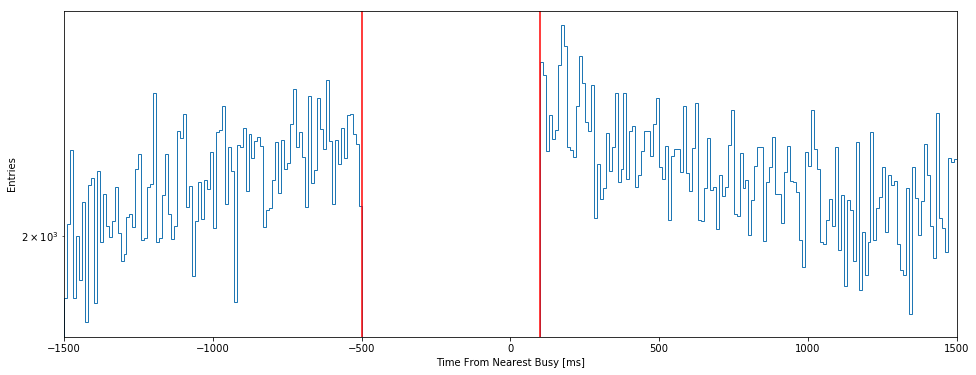

In [32]:
plt.rcParams['figure.figsize'] = (16, 6)
fig = plt.figure()

plt.hist(df.nearest_busy/1e6, range = [-1.5e3, 1.5e3], bins = 300, histtype = 'step')
plt.axvline(-0.5e3, color = 'r')
plt.axvline(0.1e3, color = 'r')
plt.yscale('log')

plt_config(xlabel = 'Time From Nearest Busy [ms]', ylabel = 'Entries', xbounds = [-1.5e3, 1.5e3])
plt.show()

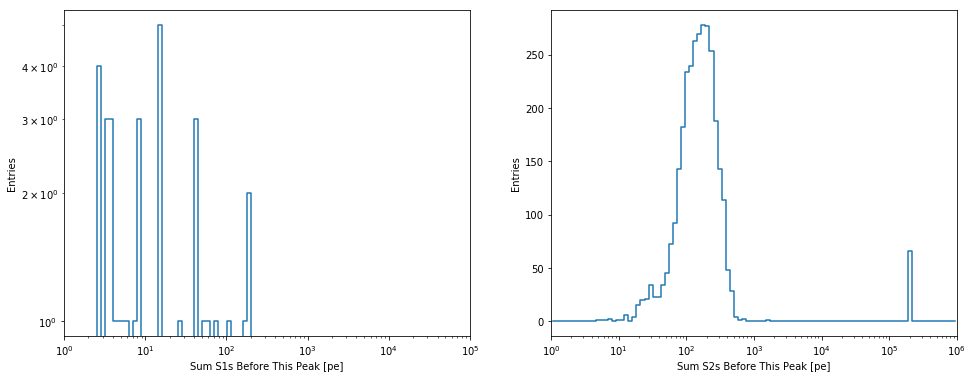

In [34]:
plt.rcParams['figure.figsize'] = (16, 6)
fig = plt.figure()

ax = fig.add_subplot(121)

little_selection = ['(nearest_busy/1e6 < 100)', '(delay > 500e6)', 
                    '(previous_largest_s2_area_sum > 0)']
little_selection = '&'.join(little_selection)

dfs = ['df[df.eval(little_selection)]']
argx = '{df}.sum_s1s_before'
ph = Hist1d(eval(argx.format(df = dfs[0])), bins = np.logspace(0, 5, 101))
ph.plot()
plt.xscale('log'); plt.yscale('log')
plt_config(xlabel = 'Sum S1s Before This Peak [pe]', ylabel = 'Entries', xbounds = [1, 1e5])


ax = fig.add_subplot(122)
argx = '{df}.sum_s2s_before'
ph = Hist1d(eval(argx.format(df = dfs[0])), bins = np.logspace(0, 6, 101))
ph.plot()
plt.xscale('log')
plt_config(xlabel = 'Sum S2s Before This Peak [pe]', ylabel = 'Entries', xbounds = [1, 1e6])


plt.show()

In [48]:
df.columns

Index(['area', 'area_fraction_top', 'event_number', 'global_event_number',
       'hit_time_mean_global', 'nearest_busy', 'previous_largest_s2_area',
       'previous_largest_s2_index', 'previous_largest_s2_time',
       'previous_s2_areas', 'previous_s2_times', 'range_50p_area',
       'run_number', 'sum_s1s_before', 'sum_s2s_before', 'delay',
       'previous_largest_s2_area_sum'],
      dtype='object')

In [ ]:
plt.rcParams['figure.figsize'] = (16, 6)
fig = plt.figure()

plt.hist(df.nearest_busy/1e6, range = [-1.5e3, 1.5e3], bins = 300, histtype = 'step')
plt.axvline(-0.5e3, color = 'r')
plt.axvline(0.1e3, color = 'r')
plt.yscale('log')

plt_config(xlabel = 'Time From Nearest Busy [ms]', ylabel = 'Entries', xbounds = [-1.5e3, 1.5e3])
plt.show()

In [35]:
#little_selection = ['']
#little_selection = '&'.join(little_selection)

#ph = Hist1d(df.loc['sum_s2s_before'], bins = np.logspace(0, 6, 101))
#plt.xscale('log')
#ph.plot()

x = df.loc[df.eval('((nearest_busy/1e6 > 100) | (nearest_busy/1e6 < -500)) & (delay > 125e6)') & (df.sum_s2s_before>500), ['event_number', 
    'delay','run_number', 'sum_s2s_before','global_event_number', 'area']]

x = x.sort_values(by = ['global_event_number'])
x.global_event_number.unique()

array([  6.73500936e+09,   6.73601435e+09,   6.76300144e+09,
         6.76301586e+09,   6.76301672e+09,   6.76600372e+09,
         6.77001674e+09,   6.77201335e+09,   6.78101813e+09,
         6.78600676e+09,   6.78800232e+09,   6.79001186e+09,
         6.79200001e+09,   6.79600939e+09,   6.79901632e+09,
         6.80000078e+09,   6.80200207e+09,   6.80401124e+09,
         6.80801510e+09,   6.81701167e+09,   6.81800684e+09,
         6.82501583e+09,   6.82601679e+09,   6.83900143e+09,
         6.90100650e+09,   6.91801270e+09,   6.92200003e+09,
         6.92500832e+09,   6.94400549e+09,   6.94501615e+09,
         6.94501682e+09,   6.94600931e+09,   6.99600643e+09,
         7.01101907e+09,   7.03601080e+09,   7.04100447e+09,
         7.04600681e+09,   7.05202024e+09,   7.05202128e+09,
         7.05800343e+09,   7.10700066e+09,   7.10801807e+09,
         7.11401505e+09,   7.18200558e+09,   7.20301426e+09,
         7.20501369e+09,   7.20701775e+09,   7.20801763e+09,
         7.22200069e+09,

In [36]:
x.head(3).to_pickle('/home/zhut/Cool_Electrons/data/bigbefore.pkl')

import hax
hax.init(pax_version='v6.8.0', raw_data_local_path = ['/project/lgrandi/xenon1t/raw_for_waveforms'])
import datetime

In [47]:
for i in range(3):
    plt.rcParams['figure.figsize'] = (16, 6)
    fig = plt.figure()
    hax.raw_data.inspect_events(x['run_number'].values[i],[x.event_number.values[i]], save_to_dir = os.getcwd())
    

processor MainProcess L66 INFO This is PAX version 6.9.0, running with configuration for XENON1T.
ReadZipped MainProcess L102 INFO InputFromFolder: Selecting file /project/lgrandi/xenon1t/raw_for_waveforms/170202_2148/XENON1T-6735-000009000-000009999-000001000.zip (number 1/2 in folder) for reading
processor MainProcess L66 INFO This is PAX version 6.9.0, running with configuration for XENON1T.
ReadZipped MainProcess L102 INFO InputFromFolder: Selecting file /project/lgrandi/xenon1t/raw_for_waveforms/170202_2248/XENON1T-6736-000002000-000002999-000001000.zip (number 1/4 in folder) for reading
ReadZipped MainProcess L102 INFO InputFromFolder: Selecting file /project/lgrandi/xenon1t/raw_for_waveforms/170202_2248/XENON1T-6736-000014000-000014999-000001000.zip (number 4/4 in folder) for reading
processor MainProcess L66 INFO This is PAX version 6.9.0, running with configuration for XENON1T.
ReadZipped MainProcess L102 INFO InputFromFolder: Selecting file /project/lgrandi/xenon1t/raw_for_wa